# Powertrain for UAV

In [77]:
%matplotlib inline
from scipy.integrate import quad, ode, odeint
from scipy import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

nsteps = lambda x: np.linspace(0, x, 100)


### Battery profile

In [276]:
def get_poly(curve, pwr=5):
    """
        @brief: gets the coefficients for a polynomial approximation of given curve
        
        @input:
            curve: the curve as an np.array
            pwr: power of the curve to fit, default=5
        
        @output:
            an np.array of length(pwr) representing the coefficients of the curve
    """ 
    x_poly = np.arange(0, len(curve))
    y_poly = np.polyfit(x_poly, curve, pwr)
    return y_poly

def get_battery_curves(soc_ocv_file, R0_degradation_file, Q_degradation_file):
    """
        @brief: gets the degradation profile (predefined curves) for the battery
        
        @input:
            soc_ocv_file: a csv file containing the soc_ocv relationship as a column vector
            R0_degradation_file: a csv file containing the R0 degradation curve as a column vector
            Q_degradation_file: a csv file containing the Q degradation curve as a column vector
        
        @output:
            a dictionary mapping of degradation curve coefficients with ["z_coef", "r0_coef", "q_coef", "EOL"] keys
    """    
    soc_ocv = []
    R0_degradation = []
    Q_degradation = []
    
    with open(soc_ocv_file, newline='') as f:
        soc_ocv = list(csv.reader(f))
    soc_ocv = np.asarray(soc_ocv).astype(np.float)
    
    with open(R0_degradation_file, newline='') as f:
        R0_degradation = list(csv.reader(f))
    R0_degradation = np.asarray(R0_degradation).astype(np.float)
    
    with open(Q_degradation_file, newline='') as f:
        Q_degradation = list(csv.reader(f))
    Q_degradation = np.asarray(Q_degradation).astype(np.float)
    
    z_coef = get_poly(soc_ocv)
    r0_coef = get_poly(R0_degradation)
    q_coef = get_poly(Q_degradation)
    eol = len(Q_degradation)
    
    return {"z_coef": z_coef, "r0_coef": r0_coef, "q_coef": q_coef, "eol": eol, "soc_ocv": soc_ocv}



### Base Battery Cell

In [287]:
class Battery:
    def __init__(self, *args, **kwargs):
        if(len(kwargs) == 0):
            self.z_coef = np.zeros((1,1))
            self.r0_coef = np.zeros((1,1))
            self.q_coef = np.zeros((1,1))
            self.eod = 1
            self.eol = 1
        else:
            self.z_coef = kwargs["z_coef"]
            self.r0_coef = kwargs["r0_coef"]
            self.q_coef = kwargs["q_coef"]
            self.eol = kwargs["eol"]
        self.z = 1.0
        self.Ir = 0
        self.h = 0
        self.M0 = .0019
        self.M = .0092
        self.R0 = .0112
        self.R = 2.83e-4
        self.Q = 3.8695
        self.n = .9987
        self.G = 163.4413
        self.v0 = 4.2
        self.eod = 3.04
        self.RC = 3.6572
        self.ocv = self.v0
        
    def get_ocv(self):
        raise NotImplementedError
    
    def step(self, dt, current):
        raise NotImplementedError
        
    def reset(self):
        self.z = 1.0
        self.ocv = self.v0
        self.Ir = 0
        self.h = 0
        

### The Continuous Battery Cell

In [442]:
class ContinuousBatteryCell(Battery):
    def __init__(self, *args, **kwargs):
        super(ContinuousBatteryCell, self).__init__(*args, **kwargs)
        print("continuous battery cell")
        
    def get_ocv(self):
        return np.polyval(self.z_coef, self.z*100.0)
    
    def step(self, dt, current):
        pass
        
############ TODO ############# integrate into continuous battery class
np.random.seed(43)

def dzdt(soc, t, current):
    return -cbcell.n*current/cbcell.Q

def didt(Ir, t, current):
    return -1.0/cbcell.RC*Ir + 1.0/cbcell.RC*current

def dhdt(h, t, current):
    return -np.absolute(cbcell.n*current*cbcell.G/cbcell.Q)*h + cbcell.n*current*cbcell.G/cbcell.Q*cbcell.M*np.sign(current)

In [282]:
battery_coefficients = get_battery_curves('soc_ocv.csv', 'R0_degradation.csv', 'Q_degradation.csv')

continuous battery cell
[4.22139702]


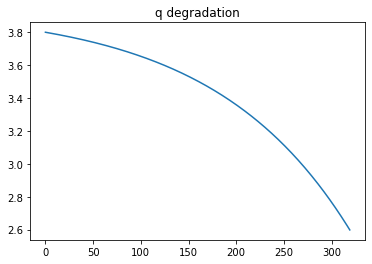

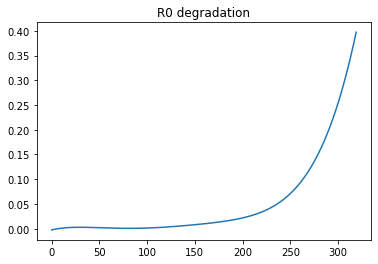

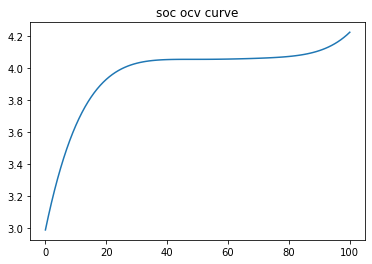

In [440]:
cbcell = ContinuousBatteryCell(**battery_coefficients)
print(cbcell.get_ocv())
plt.plot(np.arange(0, cbcell.eol), np.polyval(cbcell.q_coef, np.arange(0, cbcell.eol)))
plt.title('q degradation')
plt.show()
plt.plot(np.arange(0, cbcell.eol), np.polyval(cbcell.r0_coef, np.arange(0, cbcell.eol)))
plt.title('R0 degradation')
plt.show()
plt.plot(np.arange(0, 101), np.polyval(cbcell.z_coef, np.arange(0, 101)))
plt.title('soc ocv curve')
plt.show()

### The Discrete Battery Cell

In [359]:
class DiscreteBatteryCell(Battery):
    def __init__(self, *args, **kwargs):
        super(DiscreteBatteryCell, self).__init__(*args, **kwargs)
        self.soc_ocv = kwargs['soc_ocv']
        
    def get_ocv(self):
        if(self.z < 0.0):
            self.z = 0
        elif(self.z > 1.0):
            self.z = 1.0
        idx = int(np.ceil(self.z*100))
        if(idx > 101):
            idx = 101
        elif(idx < 1):
            idx = 1
        return self.soc_ocv[idx]
        
    def step(self, dt, current):
        RC = np.exp(-dt/abs(self.RC))
        H = np.exp(-abs(self.n*current*self.G*dt/(3600*self.Q)))
        self.Ir = RC*self.Ir + (1-RC)*current
        self.h = H*self.h + (H-1)*np.sign(current)
        self.z = self.z - self.n*current/3600/self.Q
        self.ocv = self.get_ocv() + self.M*self.h + self.M0*np.sign(current) - self.R*self.Ir - self.R0*current
        

In [441]:
dbcell = DiscreteBatteryCell(**battery_coefficients)

#### simulate the cell
- dt = 1 second, current = 3.8695
- the cell capacity is 3.8695 mAh, so, i should be ~3600 
- the cell asymptotically approaches the eod, so have to stop slightly above

simulating 3.8695 amp draw for 1 hr (3600 seconds)...
discrete soc: 0.0019
discrete seconds elapsed: 3598
continuous soc: 0.0019
continuous seconds elapsed: 3598


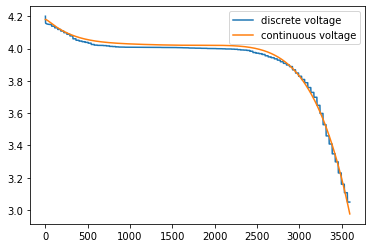

In [445]:
def continuous_test2():
    """ simulate continuous cell for 1 hr"""
    cbcell.reset()
    dt = 1/3600 # 1 second
    t1 = nsteps(dt)
    ocvs = []
    i = 0
    while(cbcell.z > .002):
        c = 3.8695
#         ocvs.append(cbcell.get_ocv() - cbcell.R*cbcell.Ir - cbcell.R0*current)
#         dz = (1 - odeint(dzdt, 1.0, t1, args=(c,))[-1][0])
#         di = odeint(didt, cbcell.Ir, t1, args=(c,))[-1]
#         cbcell.Ir = di
#         cbcell.z = cbcell.z - dz
        ocvs.append(cbcell.get_ocv() - cbcell.R*cbcell.Ir - cbcell.R0*current + cbcell.h + cbcell.M0*np.sign(current))
        dz = (1 - odeint(dzdt, 1.0, t1, args=(c,))[-1][0])
        di = odeint(didt, cbcell.Ir, t1, args=(c,))[-1][0]
        dh = odeint(dhdt, cbcell.h, t1, args=(c,))[-1][0]
        cbcell.Ir = di
        cbcell.z = cbcell.z - dz   
        cbcell.h = dh
        i += 1
    print("continuous soc: {:.4f}".format(cbcell.z))
    print("continuous seconds elapsed: " + str(i))
    return ocvs

def discrete_test2():
    """simulate discrete cell for 1 hr"""
    dbcell.reset()
    dt = 1.0
    ocvs = []
    i = 0
    while(dbcell.z > .002):
        c = 3.8695
        ocvs.append(dbcell.ocv)
        dbcell.step(1, c)
        i += 1
    print("discrete soc: {:.4f}".format(dbcell.z))
    print("discrete seconds elapsed: " + str(i))
    return ocvs

print("simulating 3.8695 amp draw for 1 hr (3600 seconds)...")

docvs = discrete_test2()
cocvs = continuous_test2()
plt.plot(docvs, label='discrete voltage')
plt.plot(cocvs, label='continuous voltage')
plt.legend()
plt.show()

### Simulate continuous cell under varying load until eod

elapsed seconds: 3429.15
ending soc: 0.0094


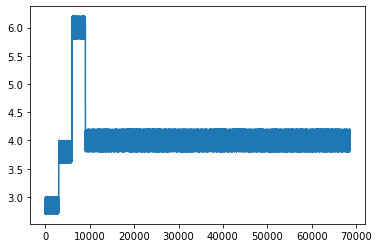

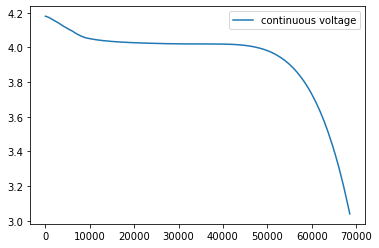

In [447]:
def continuous_test(c, dt):
    dz = (1 - odeint(dzdt, 1.0, t1, args=(c,))[-1][0])
    di = odeint(didt, cbcell.Ir, t1, args=(c,))[-1][0]
    dh = odeint(dhdt, cbcell.h, t1, args=(c,))[-1][0]
    cbcell.Ir = di
    cbcell.z = cbcell.z - dz   
    cbcell.h = dh
    cbcell.ocv = cbcell.get_ocv() - cbcell.R*cbcell.Ir - cbcell.R0*current + cbcell.h + cbcell.M0*np.sign(current)

cbcell.reset()
cs = []
cz = []
cv = []
ct = 1/3600/20
#ct = 1/3600/20 # 1/20th of a second, i.e. .05 seconds
t1 = nsteps(ct)
i = 0
while(cbcell.ocv > cbcell.eod):
    if(i < 3000):
        c = np.random.uniform(2.7, 3.0)
    elif(i >= 3000 and i <= 6000):
        c = np.random.uniform(3.6, 4.0)
    elif(i >= 6000 and i <= 9000):
        c = np.random.uniform(5.8, 6.2)
    else:
        c = np.random.uniform(3.8, 4.2) 
    continuous_test(c, ct)
    cs.append(c)
    cz.append(cbcell.z)
    cv.append(cbcell.ocv)
    i += 1
print("elapsed seconds: {:.2f}".format(i * .05))
print("ending soc: {:.4f}".format(cbcell.z))
plt.plot(cs, label='current profile')
plt.show()
plt.plot(cv, label='continuous voltage')
plt.legend()
plt.show()